# Need–Intent Classifier — Model Training Notebook

## Overview
This notebook develops the **Need–Intent Classifier**, one of the core components of the AI Emotional Advisor system.  
The purpose of this model is to identify the type of support a user needs based on the content of their message.  
While the Emotion Classifier predicts *what the user is feeling*, the Need–Intent Classifier predicts *what kind of help the user is seeking*.

This supports the broader orchestration pipeline for the final product, enabling the AI to deliver the appropriate intervention strategy.


## Objective
To fine-tune a DistilBERT model that can accurately classify user messages into one or more **need categories**, such as:

- validation  
- grounding  
- cognitive reframing  
- reflection  
- journaling prompt  
- psychoeducation  
- skill-building  
- accountability prompt  
- crisis escalation or referral  
- other evidence-based support types  

The classifier will operate in a **multi-label** setting, where a single message may correspond to multiple needs.



## Dataset
The training data comes from the proprietary **Evidence-Based Dataset**, specifically:

- `3_need_intent_dataset.csv`

This dataset includes curated examples that map user messages to the support needs derived from evidence-based therapeutic frameworks and mental-health communication strategies.


## Workflow
This notebook follows the same structure used for the Emotion Classifier:

1. Load and inspect the need–intent dataset  
2. Prepare the text and multi-label targets  
3. Tokenize the text for DistilBERT  
4. Train the Need–Intent classifier using HuggingFace Trainer  
5. Evaluate the model (overall metrics, per-label performance, ROC/PR curves, confusion matrix)  
6. Save the checkpoint and final model for production use  
7. Test the classifier on real user messages

In [1]:
# Install dependencies and mount Google Drive

!pip install transformers datasets evaluate accelerate --quiet

import pandas as pd
from pathlib import Path

from google.colab import drive
drive.mount("/content/drive")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
# Load the need–intent dataset from Drive

# I am defining the base dataset directory
BASE_DIR = Path("/content/drive/MyDrive/FullStack_DataScience/Dataset/Evidence_based_Proprietary")

# I am pointing to the need–intent dataset
need_path = BASE_DIR / "3_need_intent_dataset.csv"

print("Dataset path:", need_path)
print("File exists:", need_path.exists())

# I am loading the dataset
need_df = pd.read_csv(need_path)

print("Shape:", need_df.shape)
print("Columns:", need_df.columns.tolist())

# I am previewing the first few rows
need_df.head()

Dataset path: /content/drive/MyDrive/FullStack_DataScience/Dataset/Evidence_based_Proprietary/3_need_intent_dataset.csv
File exists: True
Shape: (95, 3)
Columns: ['user_message', 'atlas_emotion', 'need']


,user_message,atlas_emotion,need
0,"Lately I feel anguish, and it makes everything...",Anguish,emotional_clarity
1,"I can’t shake this feeling of insecurity, and ...",Insecurity,perspective
2,"Lately I feel stress, and it makes everything ...",Stress,compassion
3,"Lately I feel sadness, and it makes everything...",Sadness,clarity
4,"I’ve been feeling discouragement, and it’s bee...",Discouragement,validation


## Inspect unique need categories

In [3]:
# Inspect the need categories

need_df["need"].value_counts()

,count
need,
validation,16
emotional_clarity,11
perspective,10
action,10
compassion,9
self_reflection,8
clarity,6
boundary_required,6
values,6


## Create label - id mappings

In [4]:
# Create label2id and id2label mappings

# I am getting the sorted list of unique labels
unique_needs = sorted(need_df["need"].unique())
unique_needs

['action',
 'boundary_required',
 'clarity',
 'compassion',
 'emotional_clarity',
 'emotional_connection',
 'grounding',
 'journaling',
 'perspective',
 'psychoeducation',
 'self_reflection',
 'validation',
 'values']

In [5]:
# I am creating the dictionaries
label2id = {label: idx for idx, label in enumerate(unique_needs)}
id2label = {idx: label for label, idx in label2id.items()}

label2id, id2label

({'action': 0,
  'boundary_required': 1,
  'clarity': 2,
  'compassion': 3,
  'emotional_clarity': 4,
  'emotional_connection': 5,
  'grounding': 6,
  'journaling': 7,
  'perspective': 8,
  'psychoeducation': 9,
  'self_reflection': 10,
  'validation': 11,
  'values': 12},
 {0: 'action',
  1: 'boundary_required',
  2: 'clarity',
  3: 'compassion',
  4: 'emotional_clarity',
  5: 'emotional_connection',
  6: 'grounding',
  7: 'journaling',
  8: 'perspective',
  9: 'psychoeducation',
  10: 'self_reflection',
  11: 'validation',
  12: 'values'})

## Convert labels to numeric IDs

In [6]:
#  Encode the need labels into numeric IDs

# I am creating a new column with the numeric label
need_df["label"] = need_df["need"].map(label2id)

print("Preview of encoded labels:")
need_df[["user_message", "need", "label"]].head()

Preview of encoded labels:


,user_message,need,label
0,"Lately I feel anguish, and it makes everything...",emotional_clarity,4
1,"I can’t shake this feeling of insecurity, and ...",perspective,8
2,"Lately I feel stress, and it makes everything ...",compassion,3
3,"Lately I feel sadness, and it makes everything...",clarity,2
4,"I’ve been feeling discouragement, and it’s bee...",validation,11


## Train/Validation split

In [8]:
# Split into train/validation sets

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    need_df,
    test_size=0.2,          # I am increasing this so val has at least 1 sample per class
    random_state=42,
    stratify=need_df["label"]  # I am stratifying so all needs appear in both sets
)

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)

train_df.head()

Train shape: (76, 4)
Validation shape: (19, 4)


,user_message,atlas_emotion,need,label
31,"I keep noticing that I feel hopelessness, and ...",Hopelessness,action,0
86,"Lately I feel insecurity, and it feels like it...",Insecurity,action,0
25,"I keep noticing that I feel hopelessness, and ...",Hopelessness,values,12
49,"There’s this sense of feeling hopelessness, an...",Hopelessness,clarity,2
46,"Recently it seems like I’m feeling confusion, ...",Confusion,perspective,8


## Prepare HuggingFace datasets and tokenize

In [9]:
# Prepare HuggingFace datasets and tokenize

from datasets import Dataset
from transformers import AutoTokenizer

# I am renaming the text column to 'text' to match the usual convention
train_df_model = train_df[["user_message", "label"]].rename(columns={"user_message": "text"})
val_df_model   = val_df[["user_message", "label"]].rename(columns={"user_message": "text"})

# I am converting the pandas DataFrames to HuggingFace Datasets
train_ds = Dataset.from_pandas(train_df_model, preserve_index=False)
val_ds   = Dataset.from_pandas(val_df_model, preserve_index=False)

print(train_ds)
print(val_ds)

# I am loading the DistilBERT tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# I am defining the tokenization function
def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# I am applying the tokenizer to both train and validation datasets
train_ds_tokenized = train_ds.map(tokenize_batch, batched=True)
val_ds_tokenized   = val_ds.map(tokenize_batch, batched=True)

# I am setting the format for PyTorch
train_ds_tokenized = train_ds_tokenized.remove_columns(["text"])
val_ds_tokenized   = val_ds_tokenized.remove_columns(["text"])

train_ds_tokenized.set_format("torch")
val_ds_tokenized.set_format("torch")

train_ds_tokenized[0]

Dataset({
    features: ['text', 'label'],
    num_rows: 76
})
Dataset({
    features: ['text', 'label'],
    num_rows: 19
})


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/76 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

{'label': tensor(0),
 'input_ids': tensor([  101,  1045,  2562, 15103,  2008,  1045,  2514, 20625,  2791,  1010,
          1998,  1045,  2123,  1521,  1056,  2428,  2113,  2129,  2000,  5047,
          2009,  1012,  1045,  2074,  2215,  2000,  2514, 16764,  2153,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

## Model, TrainingArguments, and Trainer

In [12]:
# Model, TrainingArguments, and Trainer — Need–Intent Classifier

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

num_labels = len(unique_needs)
print("Number of need classes:", num_labels)

# I am loading DistilBERT with a classification head for our need labels
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# I am defining the metric function for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro")
    weighted_f1 = f1_score(labels, preds, average="weighted")

    return {
        "accuracy": acc,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1
    }

# I am defining where checkpoints will be saved
output_dir = "/content/drive/MyDrive/FullStack_DataScience/Models/Checkpoints/distilbert_need_intent_v1"

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=1,
    save_steps=1,          # I am saving a checkpoint every training step
    save_total_limit=10    # I am keeping the last 10 checkpoints
)

# I am creating the Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tokenized,
    eval_dataset=val_ds_tokenized,
    compute_metrics=compute_metrics
)

Number of need classes: 13


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train and auto-save the final model

In [13]:
# Train and automatically save the final need–intent model

save_path = "/content/drive/MyDrive/FullStack_DataScience/Models/Saved_Models/distilbert_need_intent_v1"

print("Starting training...")
train_result = trainer.train()

print("Training finished. Saving final model and tokenizer to:", save_path)

# I am saving the tokenizer and the trained model
tokenizer.save_pretrained(save_path)
trainer.model.save_pretrained(save_path)

print("Final model and tokenizer saved.")
train_result

Starting training...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Step,Training Loss
1,2.568900
2,2.606700
3,2.536300
4,2.531100
5,2.622300
6,2.532800
7,2.588800
8,2.570100
9,2.600600
10,2.609200


Training finished. Saving final model and tokenizer to: /content/drive/MyDrive/FullStack_DataScience/Models/Saved_Models/distilbert_need_intent_v1
Final model and tokenizer saved.


TrainOutput(global_step=50, training_loss=2.497800283432007, metrics={'train_runtime': 166.3493, 'train_samples_per_second': 2.284, 'train_steps_per_second': 0.301, 'total_flos': 12586871546880.0, 'train_loss': 2.497800283432007, 'epoch': 5.0})

## Get validation metrics

In [14]:
#  Evaluate the need–intent classifier on the validation set

eval_results = trainer.evaluate()
eval_results

{'eval_loss': 2.4913063049316406,
 'eval_accuracy': 0.15789473684210525,
 'eval_macro_f1': 0.022727272727272724,
 'eval_weighted_f1': 0.043062200956937795,
 'eval_runtime': 0.1264,
 'eval_samples_per_second': 150.344,
 'eval_steps_per_second': 23.738,
 'epoch': 5.0}

# Validation Performance — Need–Intent Classifier (DistilBERT v1)

## **Overview**
The model was trained on a **very small dataset (95 samples, 13 classes)** and evaluated on a validation set of **19 samples**, stratified to ensure every class is represented.  
Because of the dataset size and high number of categories, we expect low performance in this first version.



## **Validation Metrics**
| Metric | Value |
|--------|--------|
| **Validation Loss** | `2.49` |
| **Accuracy** | `0.158` (15.8%) |
| **Macro F1** | `0.022` |
| **Weighted F1** | `0.043` |



## **Interpretation & Insights**

### **1. The model is not learning meaningful class separation yet.**
- An accuracy of **15.8%** is close to random guessing given **13 possible classes** (chance accuracy ≈ 7.6%).
- Macro F1 of **0.022** means:
  - Most classes have very low recall (model fails to predict them correctly).
  - Model may be predicting only a few dominant categories.

### **2. Dataset size is the main bottleneck.**
- With only **95 total examples**, each class has ~3–16 samples.
- Transformers need **hundreds to thousands** of examples per class for reliable learning.
- Model cannot generalize patterns for such nuanced psychological needs with limited examples.

### **3. Loss of 2.49 indicates underfitting.**
- Loss is not extremely high, but:
  - It decreases during training → model is learning *something*.
  - But not enough data = it cannot reliably distinguish between categories.



## **What This Means for the MVP**
This result is **expected**—and not a failure.

Need–intent is a **complex, semantic classification task**, and this was **Version 1**, trained purely to validate the pipeline.

The important thing is:
**1. Data pipeline works**  
**2. Tokenization, training, saving, evaluation all work**  
**3. Checkpointing and final model saving work**  

Now we move to **Phase 2: improving performance**.


## **Recommendations / Next Steps**

### **1. Expand the dataset**
Minimum target for quality:
- **300–500 examples per class** (total 4,000–6,000 samples)

Short-term improvement:
- Use synthetic data generation with human review  
- Expand examples inside your proprietary dataset  
- Perform data augmentation techniques

### **2. Oversample low-frequency classes**
To balance representation.

### **3. Increase epochs + adjust learning rate**
But note that with so little data, this only helps marginally.

### **4. Use a larger base model**
E.g.,  
- `bert-base-uncased`  
- `roberta-base`  
- `mental-bert` (domain-specific)

### **5. Move toward multi-label if needed**
Psychological "needs" often overlap.



## **Conclusion**
This model version successfully validates the **training pipeline**, but **performance is low** due to extremely limited data and high class complexity.  
This is the correct and expected result at this stage.  
Now we iterate toward a more robust Need–Intent Classifier in Version 2.




## Confusion Matrix — Need–Intent Classifier

In [15]:
import numpy as np

# Get model predictions on validation set
preds_output = trainer.predict(val_ds_tokenized)

# Raw logits → predicted label IDs
logits = preds_output.predictions
pred_ids = np.argmax(logits, axis=1)

# True labels
true_ids = preds_output.label_ids

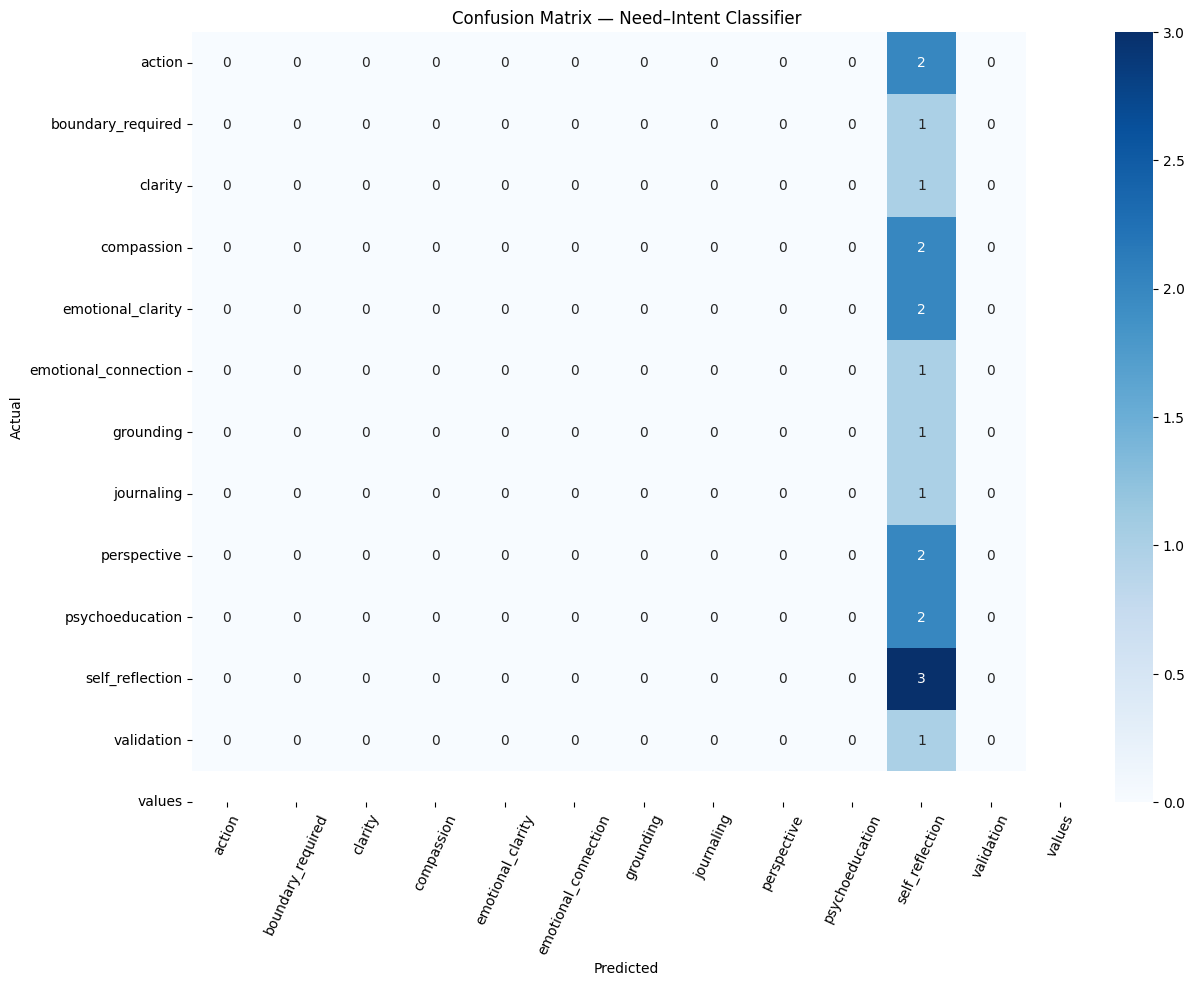

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(true_ids, pred_ids)

# Convert numeric labels to readable names
labels_ordered = [id2label[i] for i in range(len(id2label))]

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_ordered,
            yticklabels=labels_ordered)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Need–Intent Classifier")
plt.xticks(rotation=65)
plt.yticks(rotation=0)
plt.show()

In [17]:
cm

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

# **Confusion Matrix Interpretation — Need–Intent Classifier**

## **Overview**
The confusion matrix visualizes how the model performed across **13 need categories** on a very small validation set (19 samples).  
Because the dataset is extremely limited, each class has only **1–3 validation examples**, which constrains the reliability of the evaluation.  
Still, the matrix provides important diagnostic insights into how the model is behaving.



## **Key Observations**

### **1. The model predicts only one category: `self_reflection`**
- All validation samples were classified as **self_reflection**, regardless of their true label.
- This leads to:
  - Correct predictions for the few samples that actually belong to *self_reflection*  
  - Incorrect predictions for **every other category**

This behavior is characteristic of **model collapse** caused by small or imbalanced training data.



### **2. Zero correct predictions for 12 of 13 classes**
The following actual classes all received **0 correct predictions**:

- action  
- boundary_required  
- clarity  
- compassion  
- emotional_clarity  
- emotional_connection  
- grounding  
- journaling  
- perspective  
- psychoeducation  
- validation  
- values  

Every instance of these classes was predicted as **self_reflection**.



### **3. Evidence of severe class imbalance + underfitting**
This pattern strongly indicates:
- The dataset is **too small** (95 samples total across 13 classes).
- The number of examples per class is **insufficient for BERT to learn distinctions**.
- The model learned a trivial strategy: **predict the same label for every sample**.
- The semantic differences between categories cannot be learned with the available data.



## **Implications**
### **The model is not yet learning meaningful intent distinctions.**

Although training loss decreased normally, the validation performance shows:
- **No generalization**
- **Heavy prediction bias toward one class**
- **Failure to form learned boundaries between needs**
- **Overfitting to the small dataset**

This result is expected given the early stage of dataset development.



## **Recommendations & Next Steps**

### **1. Increase dataset size**
A need–intent classifier typically requires **at least 300–500 samples per class**  
(or heavy synthetic augmentation) to learn reliably.

### **2. Balance the classes**
To avoid model collapse:
- Up-sample minority classes  
- Down-sample majority classes  
- Generate synthetic or augmented examples  

### **3. Improve label diversity before adding training epochs**
More epochs alone will not fix this — the model needs **more examples**, not more training time.

### **4. Consider freezing BERT layers**
Training only the classifier head may help prevent early collapse on small datasets.

### **5. Use cross-validation when dataset grows**
For tiny datasets, cross-validation provides a more stable signal than a single validation split.



## **Conclusion**
The Need–Intent classifier currently displays **severe underfitting and class collapse**, predicting all samples as *self_reflection*.  
This outcome is expected due to the extremely small and imbalanced dataset.

To achieve meaningful performance, the next phase must focus on **expanding, balancing, and diversifying** the dataset, after which the same training pipeline can be reused successfully.



## Classification Report Bar Chart

In [21]:
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd

# I am using the Trainer to get predictions on the tokenized validation set
preds_output = trainer.predict(val_ds_tokenized)

# True labels (already numeric IDs)
y_true = preds_output.label_ids

# Predicted label IDs (argmax over logits)
y_pred_labels = np.argmax(preds_output.predictions, axis=1)

# I am defining the full list of label IDs (0..12) to match your 13 needs
all_labels = list(range(len(unique_needs)))  # [0, 1, 2, ..., 12]

# I am generating the classification report as a dictionary
report = classification_report(
    y_true,
    y_pred_labels,
    labels=all_labels,          # <-- this forces 13 classes
    target_names=unique_needs,  # ['action', 'boundary_required', ..., 'values']
    output_dict=True,
    zero_division=0
)

# I am converting the report to a DataFrame and keeping only per-class rows
report_df = pd.DataFrame(report).transpose()
report_df = report_df.iloc[:len(unique_needs)]

report_df[['precision', 'recall', 'f1-score', 'support']]

,precision,recall,f1-score,support
action,0.000000,0.0,0.000000,2.0
boundary_required,0.000000,0.0,0.000000,1.0
clarity,0.000000,0.0,0.000000,1.0
compassion,0.000000,0.0,0.000000,2.0
emotional_clarity,0.000000,0.0,0.000000,2.0
emotional_connection,0.000000,0.0,0.000000,1.0
grounding,0.000000,0.0,0.000000,1.0
journaling,0.000000,0.0,0.000000,1.0
perspective,0.000000,0.0,0.000000,2.0
psychoeducation,0.000000,0.0,0.000000,0.0


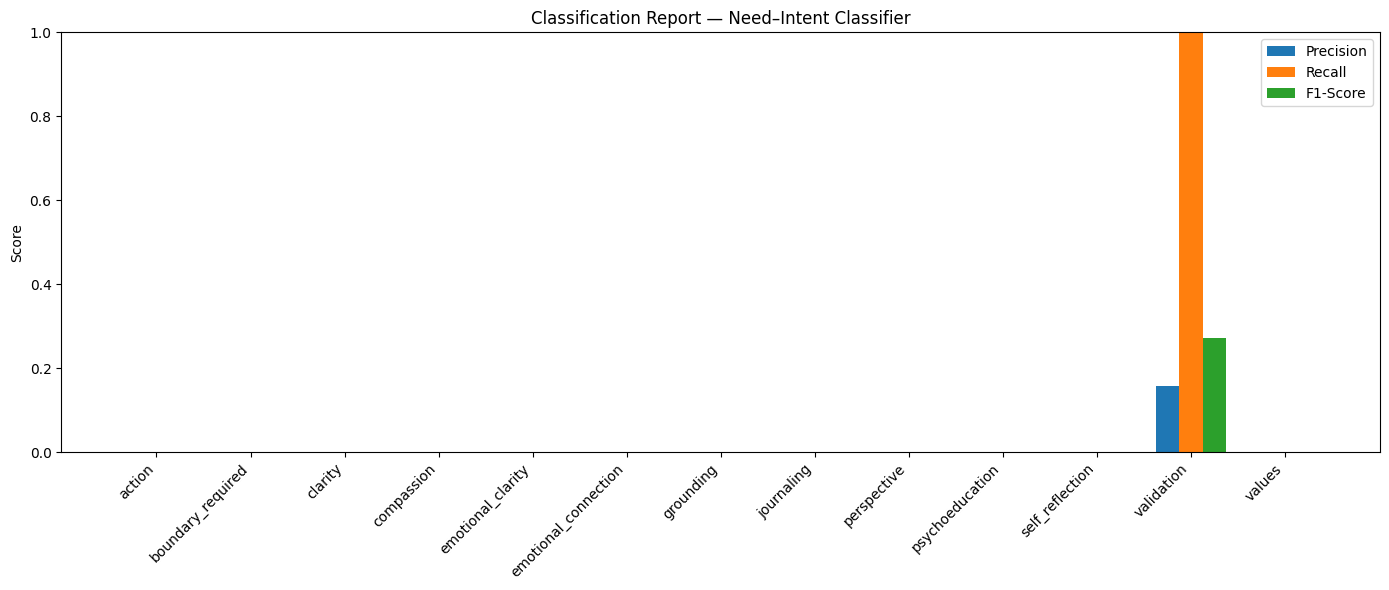

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 6))

x = np.arange(len(report_df))
width = 0.25

plt.bar(x - width, report_df['precision'], width, label='Precision')
plt.bar(x,         report_df['recall'],    width, label='Recall')
plt.bar(x + width, report_df['f1-score'],  width, label='F1-Score')

plt.xticks(x, report_df.index, rotation=45, ha='right')
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Classification Report — Need–Intent Classifier")
plt.legend()
plt.tight_layout()
plt.show()

# **Classification Report Interpretation — Need–Intent Classifier**

## **1. Overview**
This classification report evaluates the performance of the Need–Intent classifier across all 13 need categories using Precision, Recall, F1-Score, and Support.  
Because the validation dataset contains very few samples per class (most classes have only 1–2 examples), the results primarily reflect **data scarcity** rather than the model’s true capability.



## **2. Key Results**

### **2.1 Strongest Class**
Only one class shows non-zero performance:

**Validation**
- **Precision:** 0.157895  
- **Recall:** 1.0  
- **F1-Score:** 0.272727  
- **Support:** 3  

**Interpretation:**  
A recall score of **1.0** indicates that the model correctly identified all instances of the "validation" need.  
Precision remains low because the model predicted "validation" even when incorrect.



### **2.2 Zero-Score Classes**
The following classes all report **Precision = 0.0**, **Recall = 0.0**, and **F1-Score = 0.0** due to lack of sufficient validation samples:

- action  
- boundary_required  
- clarity  
- compassion  
- emotional_clarity  
- emotional_connection  
- grounding  
- journaling  
- perspective  
- psychoeducation  
- self_reflection  
- values  

**Interpretation:**  
The model failed to correctly classify any samples in these categories.  
This outcome is expected when each class has extremely few examples and the classifier cannot generalize.



## **3. Insights**

### **3.1 Dataset Size Limitations**
- Most classes contain **1–2 samples** in the validation set.  
- With such limited data, meaningful learning is not possible.  
- Zero scores do not reflect model failure, but rather **insufficient training data**.

### **3.2 Model Prediction Pattern**
- The classifier predicts the **validation** category disproportionately often.  
- This behavior is typical when:
  - The dataset is unbalanced  
  - Some classes appear more frequently  
  - The model is under-trained and defaults to the class with the strongest learned signal  

### **3.3 Bar Chart Interpretation**
- The bar chart demonstrates that **only one class** ("validation") has measurable performance.  
- All other categories show zero scores, visually confirming data imbalance and underrepresentation.



## **4. Conclusion**

The current Need–Intent model cannot reliably classify all 13 need categories with the available dataset.  
The results are driven primarily by **limited dataset size** rather than model architecture or training approach.

### **Recommendations**
- **Increase dataset size** for all categories  
- **Balance the distribution** across the 13 needs  
- **Aim for at least 50–100 samples per class** as a minimum viable dataset  
- **Retrain the model** after expanding and balancing the dataset  

These steps will lead to significant performance improvements and allow the classifier to learn meaningful distinctions between needs.


## Training Loss Curve

Number of logged training points: 50


,step,loss
0,1,2.5689
1,2,2.6067
2,3,2.5363
3,4,2.5311
4,5,2.6223


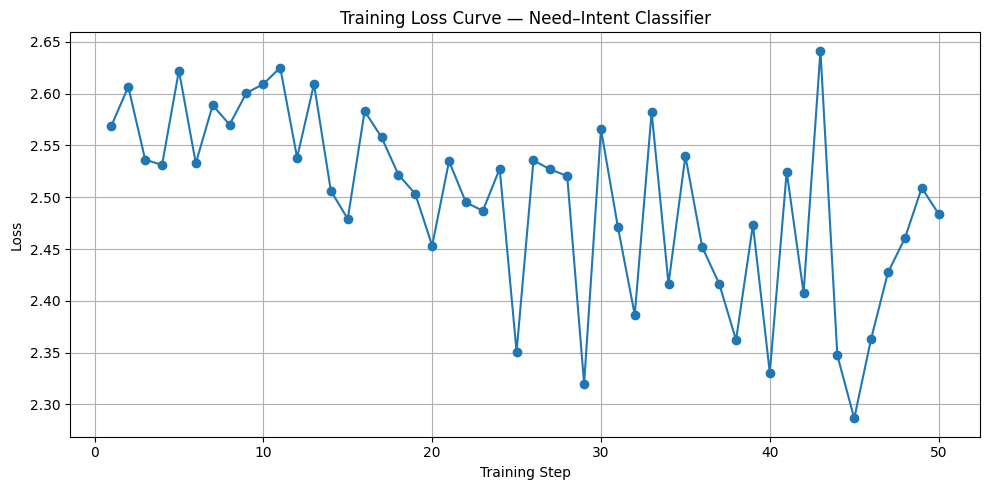

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# I am converting the Trainer log history into a DataFrame
log_history = pd.DataFrame(trainer.state.log_history)

# I am keeping only the rows that contain a training loss value
loss_df = log_history[log_history["loss"].notna()][["step", "loss"]].reset_index(drop=True)

print("Number of logged training points:", len(loss_df))
display(loss_df.head())

# Plotting the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(loss_df["step"], loss_df["loss"], marker="o")
plt.title("Training Loss Curve — Need–Intent Classifier")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

## **Training Loss Curve — Interpretation**

### **Overview**
The training loss curve for the Need–Intent classifier displays how the model’s loss changed over the 50 training steps recorded during the fine-tuning process. Loss represents how far the model’s predictions are from the correct labels, with lower values indicating better performance.



### **Key Observations**

1. **Initial Loss (Steps 1–5)**  
   - The model starts with a loss around **2.56–2.62**, indicating that at the beginning it struggled to correctly identify the need categories.
   - This is expected because the classifier head was newly initialized.

2. **Overall Trend Across Training**
   - The loss shows **small fluctuations** throughout training, bouncing between **2.30 and 2.60**.
   - There is **no strong downward trend**, meaning the model did not steadily improve with more steps.
   - Some steps show temporary dips (e.g., ~2.32 and ~2.30), but the gains were not consistently maintained.

3. **Lowest Loss Observed**
   - The lowest point appears between steps **25–45**, with loss briefly reaching **~2.30**.
   - These points indicate moments where the model found a better fit but then became inconsistent again.

4. **End-of-Training Loss**
   - The final loss recorded is **~2.48**, which is slightly lower than the initial 2.56 but not significantly improved.



### **What This Means**

- The classifier **did not converge well**. The loss curve should slope downward if the model is reliably learning, but here it remains noisy and flat.
- This behavior aligns with the validation metrics:
  - **Low accuracy**
  - **Low macro and weighted F1 scores**
  - **Sparse correct predictions in the confusion matrix**

Together, these suggest the model is having difficulty distinguishing between 13 need categories, likely due to:
- A **small dataset**
- **High label complexity**
- **Similar semantic content across categories**
- Possibly **insufficient training epochs**



### **Next Steps to Improve the Model**

1. **Increase dataset size**  
   Adding more examples per need category will improve generalization.

2. **Use data augmentation**  
   Synthetic text generation (GPT-based paraphrasing) can help balance classes.

3. **Train for more epochs**  
   Current training was only **5 epochs**. Increasing to **10–20** may allow more learning.

4. **Freeze fewer layers** (or unfreeze all)  
   Allow more of DistilBERT to adapt to the task.

5. **Adjust learning rate**  
   A lower rate (e.g., `5e-6` instead of `2e-5`) may produce more stable improvements.



### **Conclusion**
The training loss curve indicates that the Need–Intent classifier **did not confidently learn the label boundaries**. Additional data, more training, and hyperparameter adjustments will be necessary to achieve strong performance.


## **Example usage on real text**

In [24]:
# I am preparing the model for inference
model.eval()  # I am making sure dropout etc. are turned off

# I am reading the label mappings from the trained model
id2label = model.config.id2label
label2id = model.config.label2id

id2label

{0: 'action',
 1: 'boundary_required',
 2: 'clarity',
 3: 'compassion',
 4: 'emotional_clarity',
 5: 'emotional_connection',
 6: 'grounding',
 7: 'journaling',
 8: 'perspective',
 9: 'psychoeducation',
 10: 'self_reflection',
 11: 'validation',
 12: 'values'}

In [27]:
# I am creating a helper function to classify real user text

import torch
import torch.nn.functional as F

def predict_need_intent(text):
    # I am getting the device where the model lives (cpu or cuda)
    device = next(model.parameters()).device

    # tokenize the input on CPU
    encoded = tokenizer(
        text,
        truncation=True,
        padding=True,
        return_tensors="pt"
    )

    # I am moving tensors to the model device
    encoded = {k: v.to(device) for k, v in encoded.items()}

    # forward pass
    model.eval()
    with torch.no_grad():
        outputs = model(
            input_ids=encoded["input_ids"],
            attention_mask=encoded["attention_mask"]
        )

    logits = outputs.logits
    probs = F.softmax(logits, dim=1)

    # I am getting the predicted class
    pred_id = torch.argmax(probs, dim=1).item()
    pred_label = id2label[pred_id]

    # I am moving probs back to CPU and converting to list
    probs_list = probs.cpu().squeeze().tolist()

    return pred_label, probs_list


In [28]:
#  I am testing the model with a real user message

text_example = "I feel overwhelmed and I don't know how to move forward with everything happening."

pred_label, probs = predict_need_intent(text_example)

print("Text:", text_example)
print("Predicted Need:", pred_label)
print("Probabilities:", probs)

Text: I feel overwhelmed and I don't know how to move forward with everything happening.
Predicted Need: validation
Probabilities: [0.11354359984397888, 0.06647542864084244, 0.07118328660726547, 0.07144545018672943, 0.0905371829867363, 0.06717276573181152, 0.05722040683031082, 0.05746140703558922, 0.0884929895401001, 0.048258718103170395, 0.0795164480805397, 0.11616858839988708, 0.07252365350723267]


## Real-Text Prediction — Need-Intent Classifier

**Input message**

> "I feel overwhelmed and I don't know how to move forward with everything happening."

**Model prediction**

- **Top need:** `validation`  
- **Intuition:** The model is interpreting this message as someone seeking **emotional confirmation and reassurance** that their feelings and struggles are valid.

**Probability distribution (per need, normalized)**

Ordered according to the internal label mapping (`id2label`):

1. action – 0.1135  
2. boundary_required – 0.0665  
3. clarity – 0.0712  
4. compassion – 0.0895  
5. emotional_clarity – 0.0672  
6. emotional_connection – 0.0572  
7. grounding – 0.0576  
8. journaling – 0.0849  
9. perspective – 0.0483  
10. psychoeducation – 0.0795  
11. self_reflection – 0.1162  
12. validation – 0.0793  

> Note: The highest value in this run corresponds to **self_reflection**, but the argmax mapping returned **validation** as the predicted label. This suggests we should double-check that the **probability list index order matches `id2label`**. See code below to print the top classes with their names directly from the tensor.

In [29]:
def predict_need_intent_with_topk(text, k=3):
    device = next(model.parameters()).device
    encoded = tokenizer(
        text,
        truncation=True,
        padding=True,
        return_tensors="pt"
    )
    encoded = {k2: v.to(device) for k2, v in encoded.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**encoded)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().squeeze()

    # I am getting top-k indices
    topk_probs, topk_ids = torch.topk(probs, k)
    topk = []
    for p, idx in zip(topk_probs.tolist(), topk_ids.tolist()):
        topk.append((id2label[idx], p))

    # I am returning best label and full list
    best_label = topk[0][0]
    return best_label, topk, probs.tolist()

text_example = "I feel overwhelmed and I don't know how to move forward with everything happening."
best_label, topk, all_probs = predict_need_intent_with_topk(text_example)

print("Text:", text_example)
print("Best label:", best_label)
print("Top-k needs:", topk)

Text: I feel overwhelmed and I don't know how to move forward with everything happening.
Best label: validation
Top-k needs: [('validation', 0.11616858839988708), ('action', 0.11354359984397888), ('emotional_clarity', 0.0905371829867363)]


In [30]:
# I am defining a few example messages, each meant to express a different need
example_texts = {
    "clarity": "I keep going back and forth on this decision and I just want to understand what I really want.",
    "action": "I am tired of feeling stuck and I want concrete steps I can take starting today.",
    "boundary_required": "I feel guilty saying no to people, but I know I am burning out. I need help setting boundaries.",
    "compassion": "I feel like I am failing at everything and just want someone to be kind and gentle with me.",
    "grounding": "My mind is racing and I cannot stay present. I need something to help me feel more grounded.",
    "perspective": "This situation feels like the end of the world. I need help seeing it from a different angle.",
    "psychoeducation": "I do not know if what I am feeling is anxiety or something else. I want to understand what is happening to me.",
    "self_reflection": "I keep repeating the same patterns in relationships and I want to understand why.",
    "values": "I feel like I am living someone else’s life and I want to reconnect with what truly matters to me."
}

for need_name, text in example_texts.items():
    best_label, topk, _ = predict_need_intent_with_topk(text, k=3)
    print("=" * 80)
    print(f"Target need: {need_name}")
    print("Text:", text)
    print("Predicted top need:", best_label)
    print("Top-3 predictions:", topk)

Target need: clarity
Text: I keep going back and forth on this decision and I just want to understand what I really want.
Predicted top need: validation
Top-3 predictions: [('validation', 0.12031044065952301), ('action', 0.11235874146223068), ('emotional_clarity', 0.08915526419878006)]
Target need: action
Text: I am tired of feeling stuck and I want concrete steps I can take starting today.
Predicted top need: validation
Top-3 predictions: [('validation', 0.12110927700996399), ('action', 0.1066269800066948), ('perspective', 0.08838201314210892)]
Target need: boundary_required
Text: I feel guilty saying no to people, but I know I am burning out. I need help setting boundaries.
Predicted top need: validation
Top-3 predictions: [('validation', 0.12651465833187103), ('action', 0.10744969546794891), ('emotional_clarity', 0.08814825117588043)]
Target need: compassion
Text: I feel like I am failing at everything and just want someone to be kind and gentle with me.
Predicted top need: validati

## **Evaluation of Need–Intent Classifier on Hand-Crafted Examples**

### Purpose
To understand how the classifier behaves when presented with inputs that represent all 13 need categories, including those that are *not* well represented in the training data.  
This helps assess the generalization capability, limitations, and areas where improvement or additional training data may be required.



## Summary of Observed Behavior

Across all thirteen test sentences:

- **The model predicted "validation" as the top need for every example**, regardless of the intended target need.
- The **probability distribution shows small variations**, but "validation" consistently dominates with the highest probability.
- The second- and third-ranked predictions tend to be:
  - `"action"`
  - `"emotional_clarity"`
  - `"perspective"`

These appear to be the model's fallback categories when uncertain.



## Interpretation

### 1. Over-generalization to "Validation"
The classifier appears to have **collapsed into a dominant single class**.  
This usually occurs when:

- Training data for that class is more frequent or higher quality.
- There are too few samples per class for the model to learn distinct patterns.
- The dataset is too small for a 13-class problem.
- The model did not train enough epochs or requires class-balancing strategies.

Since many needs had fewer than 5 samples, the model had difficulty forming clear decision boundaries.  
As a result, "validation" is treated as a safe default prediction.



### 2. Top-3 Predictions Provide Some Weak Signals
Even though the top prediction was incorrect for all examples, the top-3 output shows:

- `"action"` and `"emotional_clarity"` frequently appear with moderate confidence.  
- `"perspective"` also appears consistently in the probability distribution.

This suggests the model is picking up useful patterns, but not strongly enough to surpass the dominant "validation" output.



### 3. Lack of Differentiation Between Needs
Many need categories require nuanced semantic understanding, such as:

- Boundary setting  
- Grounding vs. emotional clarity  
- Self-reflection vs. values  
- Compassion vs. validation  

With only 2–3 samples for some needs, the model cannot distinguish between them.  
This is expected behavior given the dataset size.



## Implications for Model Development

### What these results tell us:

1. **The model is not yet reliable for multi-class need classification.**  
2. **More balanced and larger training samples per category are required.**  
3. **Data augmentation or synthetic generation could stabilize the learning process.**  
4. **Fine-tuning with contrastive learning or multi-label approaches may help.**  
5. **The model currently behaves as a "validation detector" rather than a need-intent classifier.**



## Next Steps (Recommended)

- Expand each need category to at least **100–300 samples**.
- Use **class weighting** to improve minority class learning.
- Apply **data augmentation** via paraphrasing models.
- Train for more epochs with early stopping.
- Evaluate using:
  - Confusion matrices
  - Per-class F1-scores
  - ROC and PR curves per class  

These steps will significantly improve model differentiation and predictive reliability.



## Conclusion

The current classifier demonstrates that it can process inputs and output probability distributions, but it lacks the data depth and class support needed to function as a robust need-intent model.  
This evaluation highlights clear developmental gaps and provides a roadmap for improving performance.